<a href="https://colab.research.google.com/github/aokdata/Land_Cover_Classification/blob/main/Land_Cover_Classification_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Land Cover Classification of RGB Satellite Images

**Aidan O'Keefe**

![LandCoverClasses.png](attachment:LandCoverClasses.png)

*Samples of each of the Land Cover Classes; from top left- Annual Crop, Forest, Herbaceous Vegetation, Highway, Industrial, Pasture, Permanent Crop, Residential, River, Sea or Lake*

## Overview

A deep learning (neural network) land cover classification project using RGB satellite images (remote sensing).

## Business Understanding

The Nature Conservancy (TNC) is looking to help protect wildlife migration corridors from development/deforestation, but they can’t be everywhere at once. 

In order to help them find where to focus their efforts, we want to build Land Cover Classifier so that TNC can monitor deforestation using satellite images to observe if land starts changing from forest or vegetation to another class.  

## Data Understanding

For this project, I am using RGB satellite images from [EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification](https://zenodo.org/record/7711810#.ZCtEhOzMJQK).

This dataset contains 27,000 RGB Satellite Images across 10 classes: 
- Annual Crop
- Forest
- Herbaceous Vegetation
- Highway
- Industrial
- Pasture
- Permanent Crop
- Residential
- River
- Sea or Lake <br><br>

There are about 2,500 images per class.

In [ ]:
#Import needed libraries
import os, shutil
from PIL import Image, ImageOps

#Standard Libraries
import numpy as np
import pandas as pd

# Visualizations
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, classification_report, ConfusionMatrixDisplay

#TensorFlow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from keras import models, layers, optimizers, regularizers
from tensorflow.keras import Model
from tensorflow.data.experimental import cardinality
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense # creates densely connected layer object
from tensorflow.keras.layers import Flatten # takes 2D input and turns into 1D array
from tensorflow.keras.layers import Conv2D # convolution layer
from tensorflow.keras.layers import MaxPooling2D # max pooling layer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#Transfer Learning
from keras.applications import ResNet50, VGG19, VGG16

### Import Data and Train/Validation/Test Split

In [ ]:
#Split Images into Train and Test folders using OS and Shutil

In [ ]:
#List image path for all categories
data_AnnualCrop = '/Users/Aidan/Documents/Flatiron/Phase_5/EuroSAT_RGB/AnnualCrop'
data_Forest = '/Users/Aidan/Documents/Flatiron/Phase_5/EuroSAT_RGB/Forest'
data_HerbaceousVegetation = '/Users/Aidan/Documents/Flatiron/Phase_5/EuroSAT_RGB/HerbaceousVegetation'
data_Highway = '/Users/Aidan/Documents/Flatiron/Phase_5/EuroSAT_RGB/Highway'
data_Industrial = '/Users/Aidan/Documents/Flatiron/Phase_5/EuroSAT_RGB/Industrial'
data_Pasture = '/Users/Aidan/Documents/Flatiron/Phase_5/EuroSAT_RGB/Pasture'
data_PermanentCrop = '/Users/Aidan/Documents/Flatiron/Phase_5/EuroSAT_RGB/PermanentCrop'
data_Residential = '/Users/Aidan/Documents/Flatiron/Phase_5/EuroSAT_RGB/Residential'
data_River = '/Users/Aidan/Documents/Flatiron/Phase_5/EuroSAT_RGB/River'
data_SeaLake = '/Users/Aidan/Documents/Flatiron/Phase_5/EuroSAT_RGB/SeaLake'


new_dir = 'data/split/'

In [ ]:
#Create objects that store all the relevant image names.
imgs_AnnualCrop = [file for file in os.listdir(data_AnnualCrop) if file.endswith('.jpg')]
imgs_Forest = [file for file in os.listdir(data_Forest) if file.endswith('.jpg')]
imgs_HerbaceousVegetation = [file for file in os.listdir(data_HerbaceousVegetation) if file.endswith('.jpg')]
imgs_Highway = [file for file in os.listdir(data_Highway) if file.endswith('.jpg')]
imgs_Industrial = [file for file in os.listdir(data_Industrial) if file.endswith('.jpg')]
imgs_Pasture = [file for file in os.listdir(data_Pasture) if file.endswith('.jpg')]
imgs_PermanentCrop = [file for file in os.listdir(data_PermanentCrop) if file.endswith('.jpg')]
imgs_Residential = [file for file in os.listdir(data_Residential) if file.endswith('.jpg')]
imgs_River = [file for file in os.listdir(data_River) if file.endswith('.jpg')]
imgs_SeaLake = [file for file in os.listdir(data_SeaLake) if file.endswith('.jpg')]

In [ ]:
# Make new split folder
os.mkdir(new_dir)

In [ ]:
#Set up the Train folder and subfolders
train_folder = os.path.join(new_dir, 'train')
train_AnnualCrop = os.path.join(train_folder, 'AnnualCrop')
train_Forest = os.path.join(train_folder, 'Forest')
train_HerbaceousVegetation = os.path.join(train_folder, 'HerbaceousVegetation')
train_Highway = os.path.join(train_folder, 'Highway')
train_Industrial = os.path.join(train_folder, 'Industrial')
train_Pasture = os.path.join(train_folder, 'Pasture')
train_PermanentCrop = os.path.join(train_folder, 'PermanentCrop')
train_Residential = os.path.join(train_folder, 'Residential')
train_River = os.path.join(train_folder, 'River')
train_SeaLake = os.path.join(train_folder, 'SeaLake')


In [ ]:
#Set up the Test folder and subfolders
test_folder = os.path.join(new_dir, 'test')
test_AnnualCrop = os.path.join(test_folder, 'AnnualCrop')
test_Forest = os.path.join(test_folder, 'Forest')
test_HerbaceousVegetation = os.path.join(test_folder, 'HerbaceousVegetation')
test_Highway = os.path.join(test_folder, 'Highway')
test_Industrial = os.path.join(test_folder, 'Industrial')
test_Pasture = os.path.join(test_folder, 'Pasture')
test_PermanentCrop = os.path.join(test_folder, 'PermanentCrop')
test_Residential = os.path.join(test_folder, 'Residential')
test_River = os.path.join(test_folder, 'River')
test_SeaLake = os.path.join(test_folder, 'SeaLake')

In [ ]:
# Make the Train directories(folders)
os.mkdir(train_folder)
os.mkdir(train_AnnualCrop)
os.mkdir(train_Forest)
os.mkdir(train_HerbaceousVegetation)
os.mkdir(train_Highway)
os.mkdir(train_Industrial)
os.mkdir(train_Pasture)
os.mkdir(train_PermanentCrop)
os.mkdir(train_Residential)
os.mkdir(train_River)
os.mkdir(train_SeaLake)

# Make the Test directories(folders)
os.mkdir(test_folder)
os.mkdir(test_AnnualCrop)
os.mkdir(test_Forest)
os.mkdir(test_HerbaceousVegetation)
os.mkdir(test_Highway)
os.mkdir(test_Industrial)
os.mkdir(test_Pasture)
os.mkdir(test_PermanentCrop)
os.mkdir(test_Residential)
os.mkdir(test_River)
os.mkdir(test_SeaLake)

In [ ]:
# Compile 80% of images into folders- Train
imgs = imgs_AnnualCrop[:2400]
for img in imgs:
    origin = os.path.join(data_AnnualCrop, img)
    destination = os.path.join(train_AnnualCrop, img)
    shutil.copyfile(origin, destination)
    
imgs = imgs_Forest[:2400]
for img in imgs:
    origin = os.path.join(data_Forest, img)
    destination = os.path.join(train_Forest, img)
    shutil.copyfile(origin, destination)

imgs = imgs_HerbaceousVegetation[:2400]
for img in imgs:
    origin = os.path.join(data_HerbaceousVegetation, img)
    destination = os.path.join(train_HerbaceousVegetation, img)
    shutil.copyfile(origin, destination)
    
imgs = imgs_Highway[:2000]
for img in imgs:
    origin = os.path.join(data_Highway, img)
    destination = os.path.join(train_Highway, img)
    shutil.copyfile(origin, destination)
    
imgs = imgs_Industrial[:2000]
for img in imgs:
    origin = os.path.join(data_Industrial, img)
    destination = os.path.join(train_Industrial, img)
    shutil.copyfile(origin, destination)
    
imgs = imgs_Pasture[:1600]
for img in imgs:
    origin = os.path.join(data_Pasture, img)
    destination = os.path.join(train_Pasture, img)
    shutil.copyfile(origin, destination)
    
imgs = imgs_PermanentCrop[:2000]
for img in imgs:
    origin = os.path.join(data_PermanentCrop, img)
    destination = os.path.join(train_PermanentCrop, img)
    shutil.copyfile(origin, destination)
    
imgs = imgs_Residential[:2400]
for img in imgs:
    origin = os.path.join(data_Residential, img)
    destination = os.path.join(train_Residential, img)
    shutil.copyfile(origin, destination)
    
imgs = imgs_River[:2000]
for img in imgs:
    origin = os.path.join(data_River, img)
    destination = os.path.join(train_River, img)
    shutil.copyfile(origin, destination)
    
imgs = imgs_SeaLake[:2400]
for img in imgs:
    origin = os.path.join(data_SeaLake, img)
    destination = os.path.join(train_SeaLake, img)
    shutil.copyfile(origin, destination)

In [ ]:
# Compile other 20% of images into folders- Test
imgs = imgs_AnnualCrop[2400:] #600
for img in imgs:
    origin = os.path.join(data_AnnualCrop, img)
    destination = os.path.join(test_AnnualCrop, img)
    shutil.copyfile(origin, destination)
    
imgs = imgs_Forest[2400:] #600
for img in imgs:
    origin = os.path.join(data_Forest, img)
    destination = os.path.join(test_Forest, img)
    shutil.copyfile(origin, destination)

imgs = imgs_HerbaceousVegetation[2400:] #600
for img in imgs:
    origin = os.path.join(data_HerbaceousVegetation, img)
    destination = os.path.join(test_HerbaceousVegetation, img)
    shutil.copyfile(origin, destination)
    
imgs = imgs_Highway[2000:] #500
for img in imgs:
    origin = os.path.join(data_Highway, img)
    destination = os.path.join(test_Highway, img)
    shutil.copyfile(origin, destination)
    
imgs = imgs_Industrial[2000:] #500
for img in imgs:
    origin = os.path.join(data_Industrial, img)
    destination = os.path.join(test_Industrial, img)
    shutil.copyfile(origin, destination)
    
imgs = imgs_Pasture[1600:] #400
for img in imgs:
    origin = os.path.join(data_Pasture, img)
    destination = os.path.join(test_Pasture, img)
    shutil.copyfile(origin, destination)
    
imgs = imgs_PermanentCrop[2000:] #500
for img in imgs:
    origin = os.path.join(data_PermanentCrop, img)
    destination = os.path.join(test_PermanentCrop, img)
    shutil.copyfile(origin, destination)
    
imgs = imgs_Residential[2400:] #600
for img in imgs:
    origin = os.path.join(data_Residential, img)
    destination = os.path.join(test_Residential, img)
    shutil.copyfile(origin, destination)
    
imgs = imgs_River[2000:] #500
for img in imgs:
    origin = os.path.join(data_River, img)
    destination = os.path.join(test_River, img)
    shutil.copyfile(origin, destination)
    
imgs = imgs_SeaLake[2400:] #600
for img in imgs:
    origin = os.path.join(data_SeaLake, img)
    destination = os.path.join(test_SeaLake, img)
    shutil.copyfile(origin, destination)

In [ ]:
train_folder = 'data/split/train'
test_folder = 'data/split/test'

# Normalize images
train_gen = ImageDataGenerator(rescale=1./255, validation_split = 0.125)
test_gen = ImageDataGenerator(rescale=1./255)

#Import data as 70% Train (10% Validation of orginal data set) and 20% Test
train_generator = train_gen.flow_from_directory(train_folder,
                                                class_mode = 'categorical', 
                                                subset ='training', 
                                                batch_size=128,
                                                shuffle=True,
                                                seed=42)
                                               
val_generator= train_gen.flow_from_directory(train_folder,
                                             class_mode= 'categorical',
                                             subset = "validation",
                                             batch_size=128,
                                             shuffle=True,
                                             seed=42)

test_generator= test_gen.flow_from_directory(test_folder,
                                              class_mode= 'categorical',
                                              batch_size=128,
                                              shuffle=False,
                                              seed=42)

FileNotFoundError: ignored

In [ ]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

### Explore Data

In [ ]:
#Confirm class balance for train and test
train_classes = train_generator.classes
val_classes = val_generator.classes
test_classes = test_generator.classes

#Look at image distribution by class across train, test, and validation sets.
train_class, train_count = np.unique(train_classes, return_counts=True)
val_class, val_count = np.unique(val_classes, return_counts=True)
test_class, test_count = np.unique(test_classes, return_counts=True)

print('Train ~ {}'.format(list(zip(train_class, train_count))))
print('Validation ~ {}'.format(list(zip(val_class, val_count))))
print('Test ~ {}'.format(list(zip(test_class, test_count))))

Train ~ [(0, 2100), (1, 2100), (2, 2100), (3, 1750), (4, 1750), (5, 1400), (6, 1750), (7, 2100), (8, 1750), (9, 2100)]
Validation ~ [(0, 300), (1, 300), (2, 300), (3, 250), (4, 250), (5, 200), (6, 250), (7, 300), (8, 250), (9, 300)]
Test ~ [(0, 600), (1, 600), (2, 600), (3, 500), (4, 500), (5, 400), (6, 500), (7, 600), (8, 500), (9, 600)]


In [ ]:
#Checking the classes in our train data 
train_class_names = train_generator.class_indices
print('Train:', train_class_names)

#Checking the classes in our validation data
val_class_names = val_generator.class_indices
print('Validation:', val_class_names)

#Checking the classes in our test data
test_class_names = test_generator.class_indices
print('Train:', test_class_names)

Train: {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}
Validation: {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}
Train: {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [ ]:
# Preview the shape of both the images and labels for both the train, validation, and test sets (8 objects total)
print("Train")
print(np.shape(train_images))
print(np.shape(train_labels))
print("Validation")
print(np.shape(val_images))
print(np.shape(val_labels))
print("Test")
print(np.shape(test_images))
print(np.shape(test_labels))

Train
(128, 256, 256, 3)
(128, 10)
Validation
(128, 256, 256, 3)
(128, 10)
Test
(128, 256, 256, 3)
(128, 10)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


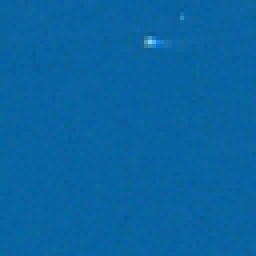

In [ ]:
# Preview a train data image
print(train_labels[0])
array_to_img(train_images[0])

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


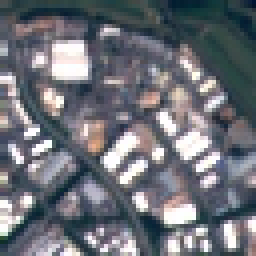

In [ ]:
# Preview a test data image
print(test_labels[0])
array_to_img(test_images[0])

## Modeling

### Baseline Model

For our baseline model, we will create a simple Sequential Neural Network with one Convolutional Layer, one Max Pooling Layer, and one Dense Layer (not including our output layer). 

In [ ]:
#Instantiate a Sequential model
baseline_model = Sequential()


# Input Layer- Convolution
baseline_model.add(Conv2D(filters=32,
                          kernel_size=(3, 3),
                          activation='relu',
                          input_shape= (256, 256, 3)))


# Layer 1- max pool in 2x2 window
baseline_model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2- connect all nodes with dense layer
baseline_model.add(Flatten())
baseline_model.add(Dense(64, activation='relu'))

# Output Layer- softmax activiation for multi-categorical with 10 classes
baseline_model.add(Dense(10, activation='softmax'))

#Compile the sequential CNN model- adam optimizer, 
# categorical_crossentropy loss, and set our metric to accuracy
baseline_model.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

# print model summary
baseline_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 516128)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                33032256  
_________________________________________________________________
dense_7 (Dense)              (None, 10)                650       
Total params: 33,033,802
Trainable params: 33,033,802
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Fit the model 
baseline_history = baseline_model.fit(train_generator, 
                                      epochs = 20, 
                                      batch_size= 128, 
                                      verbose = 1, 
                                      validation_data = val_generator)

Epoch 1/20
148/148 [==============================] - 327s 2s/step - loss: 3.3877 - accuracy: 0.2939 - val_loss: 1.6197 - val_accuracy: 0.3700
Epoch 2/20
148/148 [==============================] - 353s 2s/step - loss: 1.5218 - accuracy: 0.4223 - val_loss: 1.4075 - val_accuracy: 0.4696
Epoch 3/20
148/148 [==============================] - 375s 3s/step - loss: 1.2251 - accuracy: 0.5588 - val_loss: 1.0713 - val_accuracy: 0.6007
Epoch 4/20
148/148 [==============================] - 310s 2s/step - loss: 1.0015 - accuracy: 0.6423 - val_loss: 1.0096 - val_accuracy: 0.6422
Epoch 5/20
148/148 [==============================] - 296s 2s/step - loss: 0.8978 - accuracy: 0.6808 - val_loss: 0.9568 - val_accuracy: 0.6426
Epoch 6/20
148/148 [==============================] - 296s 2s/step - loss: 0.8389 - accuracy: 0.7003 - val_loss: 0.9141 - val_accuracy: 0.6644
Epoch 7/20
148/148 [==============================] - 298s 2s/step - loss: 0.7665 - accuracy: 0.7302 - val_loss: 0.9494 - val_accuracy: 0.6615

In [ ]:
#Check loss and accuracy on test data
test_loss, test_acc = baseline_model.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

43/43 [==============================] - 25s 585ms/step - loss: 1.0459 - accuracy: 0.7411
Test loss:  1.0459473133087158
Test accuracy:  0.7411110997200012


It looks like after 20 Epochs our baseline model overfit with a 96.4% train accuracy and a 74.1% test accuracy. In the future, we will also want to use Early Stopping to prevent the model from continuing to overfit. 

### First Model

Let's make our CNN "deeper" and add additonal convolution and max pooling layers.

In [ ]:
#Instantiate a Sequential model
model_one = Sequential()


# Input Layer- Convolution
model_one.add(Conv2D(filters=32,
                          kernel_size=(3, 3),
                          activation='relu',
                          input_shape= (256, 256, 3)))


# Layer 1- max pool in 2x2 window
model_one.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2- another convolution layer 
model_one.add(layers.Conv2D(32, (3, 3), activation='relu'))

# Layer 3- another max pool layer
model_one.add(layers.MaxPooling2D((2, 2)))

# Layer 4- connect all nodes with dense layer
model_one.add(Flatten())
model_one.add(Dense(64, activation='relu'))

# Output Layer- softmax activiation for multi-categorical with 10 classes
model_one.add(Dense(10, activation='softmax'))

#Compile the sequential CNN model- adam optimizer, 
# categorical_crossentropy loss, and set our metric to accuracy
model_one.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

# print model summary
model_one.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 123008)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                7872576   
_________________________________________________________________
dense_9 (Dense)              (None, 10)               

Let's also add a stopping criteria as well.

In [ ]:
# Define Stopping Criteria 
valcallback = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience = 2)


# Fit the model
model_one_history = model_one.fit(train_generator, 
                                  epochs= 20, 
                                  validation_data = val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

Epoch 1/20
148/148 [==============================] - 444s 3s/step - loss: 1.5299 - accuracy: 0.4476 - val_loss: 1.1410 - val_accuracy: 0.5926
Epoch 2/20
148/148 [==============================] - 452s 3s/step - loss: 1.0054 - accuracy: 0.6348 - val_loss: 0.9596 - val_accuracy: 0.6463
Epoch 3/20
148/148 [==============================] - 449s 3s/step - loss: 0.8038 - accuracy: 0.7134 - val_loss: 0.8036 - val_accuracy: 0.6993
Epoch 4/20
148/148 [==============================] - 490s 3s/step - loss: 0.6379 - accuracy: 0.7755 - val_loss: 0.7442 - val_accuracy: 0.7374
Epoch 5/20
148/148 [==============================] - 553s 4s/step - loss: 0.5075 - accuracy: 0.8248 - val_loss: 0.6600 - val_accuracy: 0.7711
Epoch 6/20
148/148 [==============================] - 451s 3s/step - loss: 0.4197 - accuracy: 0.8556 - val_loss: 0.7485 - val_accuracy: 0.7367
Epoch 7/20
148/148 [==============================] - 440s 3s/step - loss: 0.3318 - accuracy: 0.8915 - val_loss: 0.6621 - val_accuracy: 0.7807

In [ ]:
#Check loss and accuracy on test data
test_loss, test_acc = model_one.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

43/43 [==============================] - 36s 827ms/step - loss: 0.6744 - accuracy: 0.7857
Test loss:  0.6743987798690796
Test accuracy:  0.7857407331466675


Making our model deeper and adding early stopping seemed to help; our model stopped after 7 Epochs once validation loss stopped decreasing. Our model is still overfit but less so with a 89.2% Train accuracy and a 78.6% Test accuracy.

### Adding Regularization

To help with the consistent overfitting, let's try out a few regularization techniques: L1, L2, and Dropout Layers.

#### Model 2- L1 Regularization

In [ ]:
#Instantiate a Sequential model
model_l1 = Sequential()


# Input Layer- Convolution
model_l1.add(Conv2D(filters=32,
                          kernel_size=(3, 3),
                          activation='relu',
                          input_shape= (256, 256, 3),
                     kernel_regularizer=regularizers.l1(0.005)))


# Layer 1- max pool in 2x2 window
model_l1.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2- another convolution layer 
model_l1.add(layers.Conv2D(32, (3, 3), 
                            activation='relu', 
                            kernel_regularizer=regularizers.l1(0.005)))

# Layer 3- another max pool layer
model_l1.add(layers.MaxPooling2D((2, 2)))

# Layer 4- connect all nodes with dense layer
model_l1.add(Flatten())
model_l1.add(Dense(64, 
                    activation='relu', 
                    kernel_regularizer=regularizers.l1(0.005)))

# Output Layer- softmax activiation for multi-categorical with 10 classes
model_l1.add(Dense(10, activation='softmax'))

#Compile the sequential CNN model- adam optimizer, 
# categorical_crossentropy loss, and set our metric to accuracy
model_l1.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

# print model summary
model_l1.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 123008)            0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                7872576   
_________________________________________________________________
dense_19 (Dense)             (None, 10)              

In [ ]:
# Define Stopping Criteria 
valcallback = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience = 2)


# Fit the model
model_l1_history = model_l1.fit(train_generator, 
                                  epochs= 20, 
                                  validation_data = val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

Epoch 1/20
148/148 [==============================] - 442s 3s/step - loss: 13.5989 - accuracy: 0.1928 - val_loss: 7.3832 - val_accuracy: 0.2019
Epoch 2/20
148/148 [==============================] - 432s 3s/step - loss: 7.1454 - accuracy: 0.2334 - val_loss: 6.8890 - val_accuracy: 0.2422
Epoch 3/20
148/148 [==============================] - 433s 3s/step - loss: 6.8911 - accuracy: 0.2394 - val_loss: 6.7559 - val_accuracy: 0.2585
Epoch 4/20
148/148 [==============================] - 440s 3s/step - loss: 6.7881 - accuracy: 0.2473 - val_loss: 6.7858 - val_accuracy: 0.2333
Epoch 5/20
148/148 [==============================] - 426s 3s/step - loss: 6.7365 - accuracy: 0.2517 - val_loss: 6.7388 - val_accuracy: 0.2959
Epoch 6/20
148/148 [==============================] - 431s 3s/step - loss: 6.7060 - accuracy: 0.2513 - val_loss: 6.6780 - val_accuracy: 0.2541
Epoch 7/20
148/148 [==============================] - 428s 3s/step - loss: 6.6548 - accuracy: 0.2603 - val_loss: 6.6618 - val_accuracy: 0.231

In [ ]:
#Check loss and accuracy on test data
test_loss, test_acc = model_l1.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

43/43 [==============================] - 33s 768ms/step - loss: 6.5977 - accuracy: 0.2669
Test loss:  6.597667217254639
Test accuracy:  0.26685184240341187


#### Model 3- L2 Regularization

In [ ]:
#Instantiate a Sequential model
model_l2 = Sequential()


# Input Layer- Convolution
model_l2.add(Conv2D(filters=32,
                          kernel_size=(3, 3),
                          activation='relu',
                          input_shape= (256, 256, 3),
                     kernel_regularizer=regularizers.l2(0.005)))


# Layer 1- max pool in 2x2 window
model_l2.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2- another convolution layer 
model_l2.add(layers.Conv2D(32, (3, 3), 
                            activation='relu', 
                            kernel_regularizer=regularizers.l2(0.005)))

# Layer 3- another max pool layer
model_l2.add(layers.MaxPooling2D((2, 2)))

# Layer 4- connect all nodes with dense layer
model_l2.add(Flatten())
model_l2.add(Dense(64, 
                    activation='relu', 
                    kernel_regularizer=regularizers.l2(0.005)))

# Output Layer- softmax activiation for multi-categorical with 10 classes
model_l2.add(Dense(10, activation='softmax'))

#Compile the sequential CNN model- adam optimizer, 
# categorical_crossentropy loss, and set our metric to accuracy
model_l2.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

# print model summary
model_l2.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 123008)            0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                7872576   
_________________________________________________________________
dense_21 (Dense)             (None, 10)              

In [ ]:
# Define Stopping Criteria 
valcallback = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience = 2)


# Fit the model
model_l2_history = model_l2.fit(train_generator, 
                                  epochs= 20, 
                                  validation_data = val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

Epoch 1/20
148/148 [==============================] - 432s 3s/step - loss: 2.1379 - accuracy: 0.3422 - val_loss: 1.9591 - val_accuracy: 0.3393
Epoch 2/20
148/148 [==============================] - 430s 3s/step - loss: 1.6320 - accuracy: 0.4792 - val_loss: 1.5435 - val_accuracy: 0.4852
Epoch 3/20
148/148 [==============================] - 430s 3s/step - loss: 1.4293 - accuracy: 0.5686 - val_loss: 1.3838 - val_accuracy: 0.5859
Epoch 4/20
148/148 [==============================] - 431s 3s/step - loss: 1.3499 - accuracy: 0.5898 - val_loss: 1.3529 - val_accuracy: 0.5700
Epoch 5/20
148/148 [==============================] - 437s 3s/step - loss: 1.2759 - accuracy: 0.6182 - val_loss: 1.2808 - val_accuracy: 0.6100
Epoch 6/20
148/148 [==============================] - 430s 3s/step - loss: 1.2131 - accuracy: 0.6368 - val_loss: 1.1424 - val_accuracy: 0.6789
Epoch 7/20
148/148 [==============================] - 429s 3s/step - loss: 1.1644 - accuracy: 0.6528 - val_loss: 1.1429 - val_accuracy: 0.6578

In [ ]:
#Check loss and accuracy on test data
test_loss, test_acc = model_l2.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

43/43 [==============================] - 35s 806ms/step - loss: 1.1507 - accuracy: 0.6563
Test loss:  1.150733232498169
Test accuracy:  0.6562963128089905


#### Model 4- Dropout Regularization

In [ ]:
#Instantiate a Sequential model
model_dropout = Sequential()


# Input Layer- Dropout
model_dropout.add(layers.Dropout(0.2, input_shape= (256, 256, 3)))

#Convolution Layer
model_dropout.add(Conv2D(filters=32,
                          kernel_size=(3, 3),
                          activation='relu'))

# Layer 1- max pool in 2x2 window
model_dropout.add(MaxPooling2D(pool_size=(2, 2)))

model_dropout.add(layers.Dropout(0.2))

# Layer 2- another convolution layer 
model_dropout.add(layers.Conv2D(32, (3, 3), activation='relu'))

# Layer 3- another max pool layer
model_dropout.add(layers.MaxPooling2D((2, 2)))

model_dropout.add(layers.Dropout(0.2))

# Layer 4- connect all nodes with dense layer
model_dropout.add(Flatten())
model_dropout.add(Dense(64, activation='relu'))

model_dropout.add(layers.Dropout(0.2))

# Output Layer- softmax activiation for multi-categorical with 10 classes
model_dropout.add(Dense(10, activation='softmax'))

#Compile the sequential CNN model- adam optimizer, 
# categorical_crossentropy loss, and set our metric to accuracy
model_dropout.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

# print model summary
model_dropout.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_10 (Dropout)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 62, 62, 32)      

In [ ]:
# Define Stopping Criteria 
valcallback = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience = 2)


# Fit the model
model_dropout_history = model_dropout.fit(train_generator, 
                                  epochs= 20, 
                                  validation_data = val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

Epoch 1/20
148/148 [==============================] - 517s 3s/step - loss: 2.4970 - accuracy: 0.1553 - val_loss: 2.1980 - val_accuracy: 0.1674
Epoch 2/20
148/148 [==============================] - 514s 3s/step - loss: 1.9059 - accuracy: 0.2441 - val_loss: 2.0253 - val_accuracy: 0.2404
Epoch 3/20
148/148 [==============================] - 513s 3s/step - loss: 1.7884 - accuracy: 0.2856 - val_loss: 1.8434 - val_accuracy: 0.3511
Epoch 4/20
148/148 [==============================] - 514s 3s/step - loss: 1.7333 - accuracy: 0.3106 - val_loss: 1.7482 - val_accuracy: 0.3663
Epoch 5/20
148/148 [==============================] - 512s 3s/step - loss: 1.6867 - accuracy: 0.3358 - val_loss: 1.7402 - val_accuracy: 0.3463
Epoch 6/20
148/148 [==============================] - 513s 3s/step - loss: 1.6566 - accuracy: 0.3614 - val_loss: 1.6861 - val_accuracy: 0.3889
Epoch 7/20
148/148 [==============================] - 519s 4s/step - loss: 1.5778 - accuracy: 0.4080 - val_loss: 1.8090 - val_accuracy: 0.3348

In [ ]:
#Check loss and accuracy on test data
test_loss, test_acc = model_dropout.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

43/43 [==============================] - 33s 774ms/step - loss: 1.7064 - accuracy: 0.3637
Test loss:  1.7064480781555176
Test accuracy:  0.3637036979198456


#### Model 5- Dropout and L2 Regularization

In [ ]:
#Instantiate a Sequential model
model_five = Sequential()

# Input Layer- Convolution
model_five.add(Conv2D(filters=32,
                          kernel_size=(3, 3),
                          activation='relu',
                          input_shape= (256, 256, 3),
                     kernel_regularizer=regularizers.l2(0.005)))

# Layer 1- max pool in 2x2 window
model_five.add(MaxPooling2D(pool_size=(2, 2)))
model_five.add(layers.Dropout(0.2))

# Layer 2- another convolution layer 
model_five.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.005)))

# Layer 3- another max pool layer
model_five.add(layers.MaxPooling2D((2, 2)))
model_five.add(layers.Dropout(0.2))

# Layer 4- connect all nodes with dense layer
model_five.add(Flatten())
model_five.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.005)))

#Layer 5
model_five.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.005)))

# Output Layer- softmax activiation for multi-categorical with 10 classes
model_five.add(Dense(10, activation='softmax'))

#Compile the sequential CNN model- adam optimizer, 
# categorical_crossentropy loss, and set our metric to accuracy
model_five.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

# print model summary
model_five.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 62, 62, 32)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 123008)          

In [ ]:
# Define Stopping Criteria 
valcallback = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience = 2)


# Fit the model
model_five_history = model_five.fit(train_generator, 
                                  epochs= 20, 
                                  validation_data = val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

Epoch 1/20
148/148 [==============================] - 490s 3s/step - loss: 2.4675 - accuracy: 0.1976 - val_loss: 1.9717 - val_accuracy: 0.3196
Epoch 2/20
148/148 [==============================] - 490s 3s/step - loss: 1.8828 - accuracy: 0.3471 - val_loss: 1.7990 - val_accuracy: 0.3978
Epoch 3/20
148/148 [==============================] - 490s 3s/step - loss: 1.7338 - accuracy: 0.4206 - val_loss: 1.6767 - val_accuracy: 0.4407
Epoch 4/20
148/148 [==============================] - 491s 3s/step - loss: 1.6063 - accuracy: 0.4655 - val_loss: 1.5370 - val_accuracy: 0.5059
Epoch 5/20
148/148 [==============================] - 490s 3s/step - loss: 1.5095 - accuracy: 0.5031 - val_loss: 1.4821 - val_accuracy: 0.5026
Epoch 6/20
148/148 [==============================] - 502s 3s/step - loss: 1.4447 - accuracy: 0.5267 - val_loss: 1.4239 - val_accuracy: 0.5456
Epoch 7/20
148/148 [==============================] - 490s 3s/step - loss: 1.4236 - accuracy: 0.5341 - val_loss: 1.4637 - val_accuracy: 0.5156

In [ ]:
#Check loss and accuracy on test data
test_loss, test_acc = model_five.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

43/43 [==============================] - 32s 754ms/step - loss: 1.4017 - accuracy: 0.5459
Test loss:  1.4017235040664673
Test accuracy:  0.5459259152412415


### Model 6- Increasing initial Convolution Layer's Filter and Kernal size.

Also arranged Dense layers in decreasing order.

In [ ]:
#Instantiate a Sequential model
model_six = Sequential()

# Input Layer- Convolution
model_six.add(Conv2D(filters=64,
                          kernel_size=(5, 5),
                          activation='relu',
                          input_shape= (256, 256, 3)))

# Layer 1- max pool in 2x2 window
model_six.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2- another convolution layer 
model_six.add(layers.Conv2D(32, (3, 3), activation='relu'))

# Layer 3- another max pool layer
model_six.add(layers.MaxPooling2D((2, 2)))

# Layer 4- connect all nodes with dense layer
model_six.add(Flatten())
model_six.add(Dense(64, activation='relu'))

#Layer 5
model_six.add(Dense(32, activation='relu'))

# Output Layer- softmax activiation for multi-categorical with 10 classes
model_six.add(Dense(10, activation='softmax'))

#Compile the sequential CNN model- adam optimizer, 
# categorical_crossentropy loss, and set our metric to accuracy
model_six.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

# print model summary
model_six.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                7872576   
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2

In [ ]:
# Define Stopping Criteria 
valcallback = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience = 2)


# Fit the model
model_six_history = model_six.fit(train_generator, 
                                  epochs= 20, 
                                  validation_data = val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

Epoch 1/20
148/148 [==============================] - 1051s 7s/step - loss: 2.0885 - accuracy: 0.2260 - val_loss: 1.8681 - val_accuracy: 0.2626
Epoch 2/20
148/148 [==============================] - 1014s 7s/step - loss: 1.7389 - accuracy: 0.3028 - val_loss: 1.6575 - val_accuracy: 0.3219
Epoch 3/20
148/148 [==============================] - 996s 7s/step - loss: 1.5863 - accuracy: 0.3687 - val_loss: 1.5469 - val_accuracy: 0.4181
Epoch 4/20
148/148 [==============================] - 974s 7s/step - loss: 1.5005 - accuracy: 0.4251 - val_loss: 1.4903 - val_accuracy: 0.4241
Epoch 5/20
148/148 [==============================] - 955s 6s/step - loss: 1.4163 - accuracy: 0.4676 - val_loss: 1.4474 - val_accuracy: 0.4526
Epoch 6/20
148/148 [==============================] - 957s 6s/step - loss: 1.3258 - accuracy: 0.5107 - val_loss: 1.4705 - val_accuracy: 0.4389
Epoch 7/20
148/148 [==============================] - 945s 6s/step - loss: 1.2367 - accuracy: 0.5442 - val_loss: 1.3537 - val_accuracy: 0.49

In [ ]:
#Check loss and accuracy on test data
test_loss, test_acc = model_six.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

43/43 [==============================] - 59s 1s/step - loss: 1.3475 - accuracy: 0.5319
Test loss:  1.3474699258804321
Test accuracy:  0.5318518280982971


### Model 7- Add Dense(128) Layer 

In [ ]:
#Instantiate a Sequential model
model_seven = Sequential()

# Input Layer- Convolution
model_seven.add(Conv2D(filters=32,
                          kernel_size=(3, 3),
                          activation='relu',
                          input_shape= (256, 256, 3)))

# Layer 1- max pool in 2x2 window
model_seven.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2- another convolution layer 
model_seven.add(layers.Conv2D(32, (3, 3), activation='relu'))

# Layer 3- another max pool layer
model_seven.add(layers.MaxPooling2D((2, 2)))

# Layer 4- connect all nodes with dense layer
model_seven.add(Flatten())
model_seven.add(Dense(128, activation='relu'))                
                
# Layer 5- dense layer                
model_seven.add(Dense(64, activation='relu'))
                
# Layer 6- dense layer  
model_seven.add(Dense(32, activation='relu'))

# Output Layer- softmax activiation for multi-categorical with 10 classes
model_seven.add(Dense(10, activation='softmax'))

#Compile the sequential CNN model- adam optimizer, 
# categorical_crossentropy loss, and set our metric to accuracy
model_seven.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

# print model summary
model_seven.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 123008)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               15745152  
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [ ]:
# Define Stopping Criteria 
valcallback = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience = 2)


# Fit the model
model_seven_history = model_seven.fit(train_generator, 
                                  epochs= 20, 
                                  validation_data = val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

Epoch 1/20
148/148 [==============================] - 431s 3s/step - loss: 1.7042 - accuracy: 0.3772 - val_loss: 1.3390 - val_accuracy: 0.5141
Epoch 2/20
148/148 [==============================] - 429s 3s/step - loss: 1.2923 - accuracy: 0.5213 - val_loss: 1.2157 - val_accuracy: 0.5633
Epoch 3/20
148/148 [==============================] - 429s 3s/step - loss: 1.1309 - accuracy: 0.5794 - val_loss: 1.1131 - val_accuracy: 0.5915
Epoch 4/20
148/148 [==============================] - 427s 3s/step - loss: 1.0286 - accuracy: 0.6232 - val_loss: 1.0793 - val_accuracy: 0.6115
Epoch 5/20
148/148 [==============================] - 429s 3s/step - loss: 0.9325 - accuracy: 0.6661 - val_loss: 0.9119 - val_accuracy: 0.6815
Epoch 6/20
148/148 [==============================] - 429s 3s/step - loss: 0.7214 - accuracy: 0.7420 - val_loss: 0.7592 - val_accuracy: 0.7244
Epoch 7/20
148/148 [==============================] - 433s 3s/step - loss: 0.5805 - accuracy: 0.7905 - val_loss: 0.7856 - val_accuracy: 0.7289

In [ ]:
#Check loss and accuracy on test data
test_loss, test_acc = model_seven.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

43/43 [==============================] - 33s 758ms/step - loss: 0.7563 - accuracy: 0.7769
Test loss:  0.7563361525535583
Test accuracy:  0.7768518328666687


### Model 8- Deeper CNN

Adding another Convolutional with Max Pooling Layer.  Also changing our EarlyStopping callback to monitor validation accuracy instead of validation loss. 

In [ ]:
#Instantiate a Sequential model
model_eight = Sequential()


# Input Layer- Convolution
model_eight.add(Conv2D(filters=32,
                          kernel_size=(3, 3),
                          activation='relu',
                          input_shape= (256, 256, 3)))


# Layer 1- max pool in 2x2 window
model_eight.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2- another convolution layer 
model_eight.add(layers.Conv2D(32, (3, 3), activation='relu'))

# Layer 3- another max pool layer
model_eight.add(layers.MaxPooling2D((2, 2)))

# Layer 4- another convolution layer 
model_eight.add(layers.Conv2D(32, (3, 3), activation='relu'))

# Layer 5- another max pool layer
model_eight.add(layers.MaxPooling2D((2, 2)))

# Layer 6- connect all nodes with dense layer
model_eight.add(Flatten())
model_eight.add(Dense(64, activation='relu'))

# Layer 7- dense layer
model_eight.add(Dense(64, activation='relu'))

# Output Layer- softmax activiation for multi-categorical with 10 classes
model_eight.add(Dense(10, activation='softmax'))

#Compile the sequential CNN model- adam optimizer, 
# categorical_crossentropy loss, and set our metric to accuracy
model_eight.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

# print model summary
model_eight.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 28800)            

In [ ]:
# Define Stopping Criteria 
valcallback = EarlyStopping(monitor='val_accuracy', mode='max', verbose = 1, patience = 2)


# Fit the model
model_eight_history = model_eight.fit(train_generator, 
                                  epochs= 20, 
                                  validation_data = val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

Epoch 1/20
148/148 [==============================] - 527s 4s/step - loss: 1.6420 - accuracy: 0.3805 - val_loss: 1.2893 - val_accuracy: 0.5274
Epoch 2/20
148/148 [==============================] - 574s 4s/step - loss: 1.1483 - accuracy: 0.5761 - val_loss: 1.0552 - val_accuracy: 0.6193
Epoch 3/20
148/148 [==============================] - 586s 4s/step - loss: 0.9700 - accuracy: 0.6397 - val_loss: 0.8785 - val_accuracy: 0.6837
Epoch 4/20
148/148 [==============================] - 501s 3s/step - loss: 0.7638 - accuracy: 0.7220 - val_loss: 0.8687 - val_accuracy: 0.6863
Epoch 5/20
148/148 [==============================] - 478s 3s/step - loss: 0.6472 - accuracy: 0.7644 - val_loss: 0.7288 - val_accuracy: 0.7363
Epoch 6/20
148/148 [==============================] - 568s 4s/step - loss: 0.5564 - accuracy: 0.7957 - val_loss: 0.6097 - val_accuracy: 0.7800
Epoch 7/20
148/148 [==============================] - 547s 4s/step - loss: 0.4814 - accuracy: 0.8262 - val_loss: 0.6907 - val_accuracy: 0.7600

In [ ]:
#Check loss and accuracy on test data
test_loss, test_acc = model_eight.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

43/43 [==============================] - 36s 846ms/step - loss: 0.6190 - accuracy: 0.7902
Test loss:  0.619040846824646
Test accuracy:  0.7901852130889893


### Model 9- Deeper CNN with 0.5 Dropout

Adding two 0.5 Dropout Layers after two Dense layers to help address overfitting.

In [ ]:
#Instantiate a Sequential model
model_nine = Sequential()


# Input Layer- Convolution
model_nine.add(Conv2D(filters=32,
                          kernel_size=(3, 3),
                          activation='relu',
                          input_shape= (256, 256, 3)))


# Layer 1- max pool in 2x2 window
model_nine.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2- another convolution layer 
model_nine.add(layers.Conv2D(32, (3, 3), activation='relu'))

# Layer 3- another max pool layer
model_nine.add(layers.MaxPooling2D((2, 2)))

# Layer 4- another convolution layer 
model_nine.add(layers.Conv2D(32, (3, 3), activation='relu'))

# Layer 5- another max pool layer
model_nine.add(layers.MaxPooling2D((2, 2)))

# Layer 6- connect all nodes with dense layer
model_nine.add(Flatten())
model_nine.add(Dense(64, activation='relu'))
model_nine.add(layers.Dropout(0.5))

# Layer 7- dense layer
model_nine.add(Dense(32, activation='relu'))
model_nine.add(layers.Dropout(0.5))

# Output Layer- softmax activiation for multi-categorical with 10 classes
model_nine.add(Dense(10, activation='softmax'))

#Compile the sequential CNN model- adam optimizer, 
# categorical_crossentropy loss, and set our metric to accuracy
model_nine.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

# print model summary
model_nine.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 28800)            

In [ ]:
# Define Stopping Criteria 
valcallback = EarlyStopping(monitor='val_accuracy', mode='max', verbose = 1, patience = 2)


# Fit the model
model_nine_history = model_nine.fit(train_generator, 
                                  epochs= 20, 
                                  validation_data = val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

Epoch 1/20
148/148 [==============================] - 515s 3s/step - loss: 2.0381 - accuracy: 0.2160 - val_loss: 1.6584 - val_accuracy: 0.3137
Epoch 2/20
148/148 [==============================] - 539s 4s/step - loss: 1.7128 - accuracy: 0.3208 - val_loss: 1.4542 - val_accuracy: 0.4937
Epoch 3/20
148/148 [==============================] - 482s 3s/step - loss: 1.5734 - accuracy: 0.3838 - val_loss: 1.3543 - val_accuracy: 0.5067
Epoch 4/20
148/148 [==============================] - 475s 3s/step - loss: 1.4843 - accuracy: 0.4311 - val_loss: 1.2336 - val_accuracy: 0.5541
Epoch 5/20
148/148 [==============================] - 475s 3s/step - loss: 1.4023 - accuracy: 0.4672 - val_loss: 1.1401 - val_accuracy: 0.5885
Epoch 6/20
148/148 [==============================] - 477s 3s/step - loss: 1.3401 - accuracy: 0.4953 - val_loss: 1.0915 - val_accuracy: 0.6515
Epoch 7/20
148/148 [==============================] - 538s 4s/step - loss: 1.2818 - accuracy: 0.5334 - val_loss: 1.0660 - val_accuracy: 0.6463

In [ ]:
#Check loss and accuracy on test data
test_loss, test_acc = model_nine.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

43/43 [==============================] - 41s 961ms/step - loss: 0.7606 - accuracy: 0.7452
Test loss:  0.760615348815918
Test accuracy:  0.7451851963996887


### Model 10- Add Dense (16) and 0.2 Dropout Layers

Also increased number of Epochs to 50

In [ ]:
#Instantiate a Sequential model
model_ten = Sequential()


# Input Layer- Convolution
model_ten.add(Conv2D(filters=32,
                          kernel_size=(3, 3),
                          activation='relu',
                          input_shape= (256, 256, 3)))


# Layer 1- max pool in 2x2 window
model_ten.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2- another convolution layer 
model_ten.add(layers.Conv2D(32, (3, 3), activation='relu'))

# Layer 3- another max pool layer
model_ten.add(layers.MaxPooling2D((2, 2)))

# Layer 4- another convolution layer 
model_ten.add(layers.Conv2D(32, (3, 3), activation='relu'))

# Layer 5- another max pool layer
model_ten.add(layers.MaxPooling2D((2, 2)))

# Layer 6- connect all nodes with dense layer
model_ten.add(Flatten())
model_ten.add(Dense(64, activation='relu'))
model_ten.add(layers.Dropout(0.2))

# Layer 7- dense layer
model_ten.add(Dense(32, activation='relu'))
model_ten.add(layers.Dropout(0.2))

# Layer 7- dense layer
model_ten.add(Dense(16, activation='relu'))
model_ten.add(layers.Dropout(0.2))

# Output Layer- softmax activiation for multi-categorical with 10 classes
model_ten.add(Dense(10, activation='softmax'))

#Compile the sequential CNN model- adam optimizer, 
# categorical_crossentropy loss, and set our metric to accuracy
model_ten.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

# print model summary
model_ten.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 28800)            

In [ ]:
# Define Stopping Criteria 
valcallback = EarlyStopping(monitor='val_accuracy', mode='max', verbose = 1, patience = 2)


# Fit the model
model_ten_history = model_ten.fit(train_generator, 
                                  epochs= 50, 
                                  validation_data = val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

Epoch 1/50
148/148 [==============================] - 622s 4s/step - loss: 2.0001 - accuracy: 0.2441 - val_loss: 1.4877 - val_accuracy: 0.4644
Epoch 2/50
148/148 [==============================] - 544s 4s/step - loss: 1.5896 - accuracy: 0.3908 - val_loss: 1.2697 - val_accuracy: 0.5296
Epoch 3/50
148/148 [==============================] - 521s 4s/step - loss: 1.4313 - accuracy: 0.4567 - val_loss: 1.2073 - val_accuracy: 0.5552
Epoch 4/50
148/148 [==============================] - 520s 4s/step - loss: 1.3009 - accuracy: 0.5120 - val_loss: 1.0292 - val_accuracy: 0.6367
Epoch 5/50
148/148 [==============================] - 519s 4s/step - loss: 1.1568 - accuracy: 0.5681 - val_loss: 0.9088 - val_accuracy: 0.6719
Epoch 6/50
148/148 [==============================] - 528s 4s/step - loss: 1.0614 - accuracy: 0.6100 - val_loss: 0.8606 - val_accuracy: 0.7063
Epoch 7/50
148/148 [==============================] - 522s 4s/step - loss: 0.9663 - accuracy: 0.6494 - val_loss: 0.8364 - val_accuracy: 0.6933

In [ ]:
#Check loss and accuracy on test data
test_loss, test_acc = model_ten.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

43/43 [==============================] - 36s 839ms/step - loss: 0.7133 - accuracy: 0.7635
Test loss:  0.7133249044418335
Test accuracy:  0.7635185122489929


### Model 11- Wider CNN with 0.2 Dropout

In [ ]:
#Instantiate a Sequential model
model_eleven = Sequential()


# Input Layer- Convolution
model_eleven.add(Conv2D(filters=32,
                          kernel_size=(3, 3),
                          activation='relu',
                          input_shape= (256, 256, 3)))


# Layer 1- max pool in 2x2 window
model_eleven.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2- another convolution layer 
model_eleven.add(layers.Conv2D(32, (3, 3), activation='relu'))

# Layer 3- another max pool layer
model_eleven.add(layers.MaxPooling2D((2, 2)))

# Layer 4- another convolution layer 
model_eleven.add(layers.Conv2D(32, (3, 3), activation='relu'))

# Layer 5- another max pool layer
model_eleven.add(layers.MaxPooling2D((2, 2)))

# Layer 6- connect all nodes with dense layer
model_eleven.add(Flatten())
model_eleven.add(Dense(512, activation='relu'))
model_eleven.add(layers.Dropout(0.2))

# Layer 7- dense layer
model_eleven.add(Dense(256, activation='relu'))
model_eleven.add(layers.Dropout(0.2))

# Layer 7- dense layer
model_eleven.add(Dense(32, activation='relu'))
model_eleven.add(layers.Dropout(0.2))

# Output Layer- softmax activiation for multi-categorical with 10 classes
model_eleven.add(Dense(10, activation='softmax'))

#Compile the sequential CNN model- adam optimizer, 
# categorical_crossentropy loss, and set our metric to accuracy
model_eleven.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

# print model summary
model_eleven.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28800)             0

In [ ]:
# Define Stopping Criteria 
valcallback = EarlyStopping(monitor='val_accuracy', mode='max', verbose = 1, patience = 2)


# Fit the model
model_eleven_history = model_eleven.fit(train_generator, 
                                  epochs= 50, 
                                  validation_data = val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

Epoch 1/50
148/148 [==============================] - 481s 3s/step - loss: 1.8579 - accuracy: 0.2936 - val_loss: 1.3696 - val_accuracy: 0.5048
Epoch 2/50
148/148 [==============================] - 473s 3s/step - loss: 1.3091 - accuracy: 0.5207 - val_loss: 0.9868 - val_accuracy: 0.6448
Epoch 3/50
148/148 [==============================] - 472s 3s/step - loss: 1.0152 - accuracy: 0.6411 - val_loss: 0.7357 - val_accuracy: 0.7396
Epoch 4/50
148/148 [==============================] - 473s 3s/step - loss: 0.8238 - accuracy: 0.7134 - val_loss: 0.7913 - val_accuracy: 0.7152
Epoch 5/50
148/148 [==============================] - 474s 3s/step - loss: 0.7157 - accuracy: 0.7537 - val_loss: 0.6792 - val_accuracy: 0.7663
Epoch 6/50
148/148 [==============================] - 474s 3s/step - loss: 0.5819 - accuracy: 0.8019 - val_loss: 0.6211 - val_accuracy: 0.7774
Epoch 7/50
148/148 [==============================] - 473s 3s/step - loss: 0.4969 - accuracy: 0.8327 - val_loss: 0.5706 - val_accuracy: 0.8015

In [ ]:
#Check loss and accuracy on test data
test_loss, test_acc = model_eleven.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

43/43 [==============================] - 35s 810ms/step - loss: 0.7885 - accuracy: 0.7443
Test loss:  0.7884544134140015
Test accuracy:  0.744259238243103


### Larger Models in Google Colab

Our next few models are quite large so we may be best served opening and running them in Google Colab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github//aokdata/Land_Cover_Classification/blob/main/Land_Cover_Classification_Notebook.ipynb)

In [ ]:
#Mount Google Drive to access data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Model 12- Decreasing filter size over 4 Conv2D Layers and 5 Dense Layers

In [ ]:
#Import Data from Google Drive to use in Google Colab
train_folder = '/content/drive/MyDrive/Data/Land_Cover_Classification_Project/data/split/train'
test_folder = '/content/drive/MyDrive/Data/Land_Cover_Classification_Project/data/split/test'

# Normalize images
train_gen = ImageDataGenerator(rescale=1./255, validation_split = 0.125)
test_gen = ImageDataGenerator(rescale=1./255)

#Import data as 70% Train (10% Validation of orginal data set) and 20% Test
train_generator = train_gen.flow_from_directory(train_folder,
                                                class_mode = 'categorical', 
                                                subset ='training', 
                                                batch_size=128,
                                                shuffle=True,
                                                seed=42)
                                               
val_generator= train_gen.flow_from_directory(train_folder,
                                             class_mode= 'categorical',
                                             subset = "validation",
                                             batch_size=128,
                                             shuffle=True,
                                             seed=42)

test_generator= test_gen.flow_from_directory(test_folder,
                                              class_mode= 'categorical',
                                              batch_size=128,
                                              shuffle=False,
                                              seed=42)

Found 18909 images belonging to 10 classes.
Found 2701 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [ ]:
#Instantiate a Sequential model
model_twelve = Sequential()


# Input Layer- Convolution
model_twelve.add(Conv2D(filters=128,
                          kernel_size=(3, 3),
                          activation='relu',
                          input_shape= (256, 256, 3)))


# Layer 1- max pool in 2x2 window
model_twelve.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2- another convolution layer 
model_twelve.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Layer 3- another max pool layer
model_twelve.add(layers.MaxPooling2D((2, 2)))

# Layer 4- another convolution layer 
model_twelve.add(layers.Conv2D(32, (3, 3), activation='relu'))

# Layer 5- another max pool layer
model_twelve.add(layers.MaxPooling2D((2, 2)))

# Layer 6- another convolution layer 
model_twelve.add(layers.Conv2D(16, (3, 3), activation='relu'))

# Layer 7- another max pool layer
model_twelve.add(layers.MaxPooling2D((2, 2)))

# Layer 8- connect all nodes with dense layer
model_twelve.add(Flatten())
model_twelve.add(Dense(512, activation='relu'))
model_twelve.add(layers.Dropout(0.2))

# Layer 9- dense layer
model_twelve.add(Dense(256, activation='relu'))
model_twelve.add(layers.Dropout(0.2))

# Layer 10- dense layer
model_twelve.add(Dense(128, activation='relu'))
model_twelve.add(layers.Dropout(0.2))

# Layer 11- dense layer
model_twelve.add(Dense(32, activation='relu'))
model_twelve.add(layers.Dropout(0.2))

# Layer 12- dense layer
model_twelve.add(Dense(16, activation='relu'))
model_twelve.add(layers.Dropout(0.2))

# Output Layer- softmax activiation for multi-categorical with 10 classes
model_twelve.add(Dense(10, activation='softmax'))

#Compile the sequential CNN model- adam optimizer, 
# categorical_crossentropy loss, and set our metric to accuracy
model_twelve.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

# print model summary
model_twelve.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)      

In [ ]:
# Define Stopping Criteria 
valcallback = EarlyStopping(monitor='val_accuracy', mode='max', verbose = 1, patience = 5)


# Fit the model
model_twelve_history = model_twelve.fit(train_generator, 
                                  epochs= 50, 
                                  validation_data = val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

Epoch 1/50
148/148 [==============================] - 66s 386ms/step - loss: 2.0190 - accuracy: 0.2129 - val_loss: 1.7082 - val_accuracy: 0.2977
Epoch 2/50
148/148 [==============================] - 55s 374ms/step - loss: 1.6798 - accuracy: 0.3422 - val_loss: 1.3919 - val_accuracy: 0.4202
Epoch 3/50
148/148 [==============================] - 56s 375ms/step - loss: 1.4762 - accuracy: 0.3936 - val_loss: 1.2848 - val_accuracy: 0.4643
Epoch 4/50
148/148 [==============================] - 55s 373ms/step - loss: 1.3265 - accuracy: 0.4652 - val_loss: 1.1793 - val_accuracy: 0.5591
Epoch 5/50
148/148 [==============================] - 55s 373ms/step - loss: 1.1954 - accuracy: 0.5347 - val_loss: 1.0277 - val_accuracy: 0.6079
Epoch 6/50
148/148 [==============================] - 56s 375ms/step - loss: 1.0565 - accuracy: 0.6017 - val_loss: 1.1026 - val_accuracy: 0.6287
Epoch 7/50
148/148 [==============================] - 55s 372ms/step - loss: 0.9683 - accuracy: 0.6546 - val_loss: 0.8653 - val_ac

In [ ]:
#Check loss and accuracy on test data
test_loss, test_acc = model_twelve.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

43/43 [==============================] - 14s 321ms/step - loss: 0.7148 - accuracy: 0.8069
Test loss:  0.7148383855819702
Test accuracy:  0.806851863861084


### Model 13- Transfer Learning: ResNet50

In [ ]:
train_folder = '/content/drive/MyDrive/Data/Land_Cover_Classification_Project/data/split/train'
test_folder = '/content/drive/MyDrive/Data/Land_Cover_Classification_Project/data/split/test'

# Normalize images
train_gen = ImageDataGenerator(rescale=1./255, 
                               preprocessing_function = tf.keras.applications.resnet50.preprocess_input,
                               validation_split = 0.125)
test_gen = ImageDataGenerator(rescale=1./255, 
                              preprocessing_function = tf.keras.applications.resnet50.preprocess_input)

#Import data as 70% Train (10% Validation of orginal data set) and 20% Test
rn_train_generator = train_gen.flow_from_directory(train_folder,
                                                class_mode = 'categorical', 
                                                subset ='training', 
                                                batch_size=128,
                                                shuffle=True,
                                                seed=42)
                                               
rn_val_generator= train_gen.flow_from_directory(train_folder,
                                             class_mode= 'categorical',
                                             subset = "validation",
                                             batch_size=128,
                                             shuffle=True,
                                             seed=42)

rn_test_generator= test_gen.flow_from_directory(test_folder,
                                              class_mode= 'categorical',
                                              batch_size=128,
                                              shuffle=False,
                                              seed=42)

Found 18909 images belonging to 10 classes.
Found 2701 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [ ]:
# Instantiate our Transfer Model Input Layer
rn50 = ResNet50(weights='imagenet', 
                 include_top=False,
                input_shape=(256, 256, 3))

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
#Check to ensure there is no prediction layer
rn50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
#Instantiate a Sequential model
rn50_model = Sequential()

#Input Layer
rn50_model.add(rn50)

rn50_model.add(layers.Flatten())

#Add Dense Layer
rn50_model.add(layers.Dense(64, activation='relu'))

#Output Layer
rn50_model.add(layers.Dense(10, activation='softmax'))

In [ ]:
# Check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in rn50_model.layers:
    print(layer.name, layer.trainable)
    
# Similarly, you can check how many trainable weights are in the model
print(len(rn50_model.trainable_weights))

resnet50 True
flatten True
dense True
dense_1 True
216


In [ ]:
# Freeze our RN50 Layer
rn50.trainable = False

# Sanity Check that RN50 layer is frozen
for layer in rn50_model.layers:
    print(layer.name, layer.trainable)

resnet50 False
flatten True
dense True
dense_1 True


In [ ]:
#Compile the model- adam optimizer, categorical_crossentropy loss, and set our metric to accuracy
rn50_model.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

# print model summary
rn50_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 64)                8388672   
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 31,977,034
Trainable params: 8,389,322
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
# Define Stopping Criteria 
valcallback = [EarlyStopping(monitor='val_accuracy', mode='max', verbose = 1, patience = 2), 
               ModelCheckpoint(filepath='rn50_model.h5', monitor='val_accuracy', save_best_only=True)]


# Fit the model
rn50_model_history = rn50_model.fit(rn_train_generator, 
                                  epochs= 50, 
                                  validation_data = rn_val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

Epoch 1/50
148/148 [==============================] - 3674s 25s/step - loss: 2.7104 - accuracy: 0.1414 - val_loss: 2.0903 - val_accuracy: 0.2177
Epoch 2/50
148/148 [==============================] - 68s 461ms/step - loss: 2.0713 - accuracy: 0.2222 - val_loss: 2.0561 - val_accuracy: 0.2307
Epoch 3/50
148/148 [==============================] - 69s 463ms/step - loss: 2.0331 - accuracy: 0.2361 - val_loss: 2.0107 - val_accuracy: 0.2403
Epoch 4/50
148/148 [==============================] - 68s 462ms/step - loss: 2.0083 - accuracy: 0.2370 - val_loss: 1.9929 - val_accuracy: 0.2418
Epoch 5/50
148/148 [==============================] - 68s 460ms/step - loss: 1.9802 - accuracy: 0.2465 - val_loss: 1.9474 - val_accuracy: 0.2725
Epoch 6/50
148/148 [==============================] - 68s 459ms/step - loss: 1.9423 - accuracy: 0.2570 - val_loss: 1.9547 - val_accuracy: 0.2403
Epoch 7/50
148/148 [==============================] - 68s 461ms/step - loss: 1.9135 - accuracy: 0.2568 - val_loss: 1.8815 - val_ac

In [ ]:
#Check loss and accuracy on test data
test_loss, test_acc = rn50_model.evaluate(rn_test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

43/43 [==============================] - 950s 23s/step - loss: 1.7919 - accuracy: 0.2861
Test loss:  1.7918556928634644
Test accuracy:  0.28611111640930176


### Model 14- Transfer Learning: VGG19

In [ ]:
train_folder = '/content/drive/MyDrive/Data/Land_Cover_Classification_Project/data/split/train'
test_folder = '/content/drive/MyDrive/Data/Land_Cover_Classification_Project/data/split/test'

# Normalize images
train_gen = ImageDataGenerator(rescale=1./255, 
                               preprocessing_function = tf.keras.applications.vgg19.preprocess_input,
                               validation_split = 0.125)
test_gen = ImageDataGenerator(rescale=1./255, 
                              preprocessing_function = tf.keras.applications.vgg19.preprocess_input)

#Import data as 70% Train (10% Validation of orginal data set) and 20% Test
vgg_train_generator = train_gen.flow_from_directory(train_folder,
                                                class_mode = 'categorical', 
                                                subset ='training', 
                                                batch_size=128,
                                                shuffle=True,
                                                seed=42)
                                               
vgg_val_generator= train_gen.flow_from_directory(train_folder,
                                             class_mode= 'categorical',
                                             subset = "validation",
                                             batch_size=128,
                                             shuffle=True,
                                             seed=42)

vgg_test_generator= test_gen.flow_from_directory(test_folder,
                                              class_mode= 'categorical',
                                              batch_size=128,
                                              shuffle=False,
                                              seed=42)

Found 18909 images belonging to 10 classes.
Found 2701 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [ ]:
#Reshape our input
vgg19 = VGG19(weights='imagenet', 
              include_top=False, 
              input_shape=(256, 256, 3))

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
#Check to ensure there is no prediction layer
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
#Instantiate a Sequential model
vgg_model = Sequential()

#Input Layer
# vgg_model.add(vgg)
vgg_model.add(vgg19)

vgg_model.add(layers.Flatten())

#Add Dense Layer
vgg_model.add(layers.Dense(64, activation='relu'))

#Output Layer
vgg_model.add(layers.Dense(10, activation='softmax'))

In [ ]:
# Check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)
    
# Similarly, you can check how many trainable weights are in the model
print(len(vgg_model.trainable_weights))

vgg19 True
flatten_1 True
dense_2 True
dense_3 True
36


In [ ]:
#Freeze our VGG19 Layer
vgg19.trainable = False

#Sanity check that VGG19 Layer is frozen
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

vgg19 False
flatten_1 True
dense_2 True
dense_3 True


In [ ]:
#Compile the model- adam optimizer, categorical_crossentropy loss, and set our metric to accuracy
vgg_model.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

# print model summary
vgg_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                2097216   
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 22,122,250
Trainable params: 2,097,866
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
# Define Stopping Criteria 
valcallback = [EarlyStopping(monitor='val_accuracy', mode='max', verbose = 1, patience = 5), 
               ModelCheckpoint(filepath='/content/drive/MyDrive/Data/Land_Cover_Classification_Project/vgg19_model.h5', 
                               monitor='val_accuracy', 
                               save_best_only=True, 
                               mode='max')]


# Fit the model
vgg_model_history = vgg_model.fit(vgg_train_generator, 
                                  epochs= 50, 
                                  validation_data = vgg_val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

Epoch 1/50
148/148 [==============================] - 77s 483ms/step - loss: 1.3647 - accuracy: 0.5560 - val_loss: 0.8784 - val_accuracy: 0.7116
Epoch 2/50
148/148 [==============================] - 68s 458ms/step - loss: 0.7692 - accuracy: 0.7433 - val_loss: 0.7042 - val_accuracy: 0.7582
Epoch 3/50
148/148 [==============================] - 68s 458ms/step - loss: 0.6222 - accuracy: 0.7888 - val_loss: 0.6486 - val_accuracy: 0.7756
Epoch 4/50
148/148 [==============================] - 68s 457ms/step - loss: 0.5468 - accuracy: 0.8129 - val_loss: 0.6318 - val_accuracy: 0.7816
Epoch 5/50
148/148 [==============================] - 68s 460ms/step - loss: 0.4730 - accuracy: 0.8388 - val_loss: 0.6117 - val_accuracy: 0.7923
Epoch 6/50
148/148 [==============================] - 68s 460ms/step - loss: 0.4401 - accuracy: 0.8512 - val_loss: 0.5157 - val_accuracy: 0.8130
Epoch 7/50
148/148 [==============================] - 68s 460ms/step - loss: 0.3914 - accuracy: 0.8692 - val_loss: 0.5857 - val_ac

In [ ]:
# Check loss and accuracy on test data
test_loss, test_acc = vgg_model.evaluate(vgg_test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

43/43 [==============================] - 18s 409ms/step - loss: 0.4333 - accuracy: 0.8570
Test loss:  0.43328657746315
Test accuracy:  0.8570370078086853


### Model 14- Transfer Learning: VGG19 with added Dense and Dropout Layers

Using the same data input and VGG19 model as Model 13 but with two Dense Layers each with a 0.2 Dropout Layer.

In [ ]:
#Instantiate a Sequential model
vgg2_model = Sequential()

#Input Layer
vgg2_model.add(vgg19)

vgg2_model.add(layers.Flatten())

#Add Dense Layer
vgg2_model.add(layers.Dense(512, activation='relu'))
vgg2_model.add(layers.Dropout(0.2))

#Add Dense Layer
vgg2_model.add(layers.Dense(64, activation='relu'))
vgg2_model.add(layers.Dropout(0.2))

#Output Layer
vgg2_model.add(layers.Dense(10, activation='softmax'))

In [ ]:
#Freeze our VGG19 Layer
vgg19.trainable = False

#Sanity check that VGG19 Layer is frozen
for layer in vgg2_model.layers:
    print(layer.name, layer.trainable)

vgg19 False
flatten True
dense True
dropout True
dense_1 True
dropout_1 True
dense_2 True


In [ ]:
#Compile the model- adam optimizer, categorical_crossentropy loss, and set our metric to accuracy
vgg2_model.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

# print model summary
vgg2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 512)               16777728  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                6

In [ ]:
# Define Stopping Criteria 
valcallback = [EarlyStopping(monitor='val_accuracy', mode='max', verbose = 1, patience = 5), 
               ModelCheckpoint(filepath='/content/drive/MyDrive/Data/Land_Cover_Classification_Project/vgg2_model.h5', 
                               monitor='val_accuracy', 
                               save_best_only=True, 
                               mode='max')]


# Fit the model
vgg2_model_history = vgg2_model.fit(vgg_train_generator, 
                                  epochs= 50, 
                                  validation_data = vgg_val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

Epoch 1/50
148/148 [==============================] - 7391s 50s/step - loss: 1.8231 - accuracy: 0.3587 - val_loss: 1.1090 - val_accuracy: 0.6342
Epoch 2/50
148/148 [==============================] - 71s 477ms/step - loss: 1.0250 - accuracy: 0.6353 - val_loss: 0.7836 - val_accuracy: 0.7212
Epoch 3/50
148/148 [==============================] - 68s 458ms/step - loss: 0.8505 - accuracy: 0.7015 - val_loss: 0.8172 - val_accuracy: 0.7212
Epoch 4/50
148/148 [==============================] - 70s 470ms/step - loss: 0.7852 - accuracy: 0.7258 - val_loss: 0.6257 - val_accuracy: 0.7719
Epoch 5/50
148/148 [==============================] - 71s 476ms/step - loss: 0.7094 - accuracy: 0.7488 - val_loss: 0.6506 - val_accuracy: 0.7775
Epoch 6/50
148/148 [==============================] - 71s 476ms/step - loss: 0.6755 - accuracy: 0.7652 - val_loss: 0.5656 - val_accuracy: 0.7967
Epoch 7/50
148/148 [==============================] - 68s 456ms/step - loss: 0.6507 - accuracy: 0.7722 - val_loss: 0.6156 - val_ac

In [ ]:
# Check loss and accuracy on test data
test_loss, test_acc = vgg2_model.evaluate(vgg_test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

43/43 [==============================] - 1876s 45s/step - loss: 0.5056 - accuracy: 0.8309
Test loss:  0.505621612071991
Test accuracy:  0.8309259414672852


### Model 15- Transfer Learning: VGG19 with Augmentation and Regularization

Adding additional images to train on through augmentation and additional dense and dropout layers.

In [ ]:
# Add augmentation (horizontal and vertical flips) to training data but not validation data.

train_folder = '/content/drive/MyDrive/Data/Land_Cover_Classification_Project/data/split/train'


# Normalize images and Augment with Horizontal and Vertical Flips
aug_train_gen = ImageDataGenerator(rescale=1./255, 
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split = 0.125, 
                               preprocessing_function = tf.keras.applications.vgg19.preprocess_input)

aug_val_gen = ImageDataGenerator(rescale=1./255, 
                                 validation_split = 0.125, 
                                 preprocessing_function = tf.keras.applications.vgg19.preprocess_input)


#Augment the train data
aug_train_generator = aug_train_gen.flow_from_directory(train_folder,
                                                class_mode = 'categorical', 
                                                subset ='training', 
                                                batch_size=128,
                                                shuffle=False,
                                                seed=42)
                                               
aug_val_generator= aug_val_gen.flow_from_directory(train_folder,
                                                   class_mode= 'categorical',
                                                   subset = "validation",
                                                   batch_size=128,
                                                   shuffle=False,
                                                   seed=42)

Found 18909 images belonging to 10 classes.
Found 2701 images belonging to 10 classes.


In [ ]:
#Reshape our input
vgg19 = VGG19(weights='imagenet', 
              include_top=False, 
              input_shape=(256, 256, 3))

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
#Check to ensure there is no prediction layer
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
#Instantiate a Sequential model
aug_vgg_model = Sequential()

#Input Layer
aug_vgg_model.add(vgg19)

aug_vgg_model.add(layers.Flatten())

#Add Dense Layer
aug_vgg_model.add(layers.Dense(512, activation='relu'))
aug_vgg_model.add(layers.Dropout(0.2))

#Add Dense Layer
aug_vgg_model.add(layers.Dense(256, activation='relu'))
aug_vgg_model.add(layers.Dropout(0.2))

#Add Dense Layer
aug_vgg_model.add(layers.Dense(128, activation='relu'))
aug_vgg_model.add(layers.Dropout(0.2))

#Add Dense Layer
aug_vgg_model.add(layers.Dense(64, activation='relu'))
aug_vgg_model.add(layers.Dropout(0.2))

#Add Dense Layer
aug_vgg_model.add(layers.Dense(32, activation='relu'))

#Output Layer
aug_vgg_model.add(layers.Dense(10, activation='softmax'))

In [ ]:
# Check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in aug_vgg_model.layers:
    print(layer.name, layer.trainable)
    
# Similarly, you can check how many trainable weights are in the model
print(len(aug_vgg_model.trainable_weights))

vgg19 True
flatten True
dense True
dropout True
dense_1 True
dropout_1 True
dense_2 True
dropout_2 True
dense_3 True
dropout_3 True
dense_4 True
dense_5 True
44


In [ ]:
#Freeze our VGG19 Layer
vgg19.trainable = False

#Sanity check that VGG19 Layer is frozen
for layer in aug_vgg_model.layers:
    print(layer.name, layer.trainable)

vgg19 False
flatten True
dense True
dropout True
dense_1 True
dropout_1 True
dense_2 True
dropout_2 True
dense_3 True
dropout_3 True
dense_4 True
dense_5 True


In [ ]:
#Compile the model- adam optimizer, categorical_crossentropy loss, and set our metric to accuracy
aug_vgg_model.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

# print model summary
aug_vgg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 512)               16777728  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               3

In [ ]:
# Define Stopping Criteria 

valcallback = [EarlyStopping(monitor='val_accuracy', mode='max', verbose = 1, patience = 5), 
               ModelCheckpoint(filepath='/content/drive/MyDrive/Data/Land_Cover_Classification_Project/aug_vgg19_model.h5', 
                               monitor='val_accuracy', 
                               save_best_only=True, 
                               mode='max')]


# Fit the model
aug_vgg_model_history = aug_vgg_model.fit(aug_train_generator, 
                                  epochs= 50, 
                                  validation_data = aug_val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

Epoch 1/50
148/148 [==============================] - 4033s 27s/step - loss: 2.4683 - accuracy: 0.1145 - val_loss: 2.1912 - val_accuracy: 0.2125
Epoch 2/50
148/148 [==============================] - 67s 452ms/step - loss: 2.1773 - accuracy: 0.1759 - val_loss: 2.2147 - val_accuracy: 0.2518
Epoch 3/50
148/148 [==============================] - 65s 435ms/step - loss: 2.1135 - accuracy: 0.2230 - val_loss: 2.1316 - val_accuracy: 0.2251
Epoch 4/50
148/148 [==============================] - 67s 454ms/step - loss: 2.0631 - accuracy: 0.2228 - val_loss: 1.9457 - val_accuracy: 0.2529
Epoch 5/50
148/148 [==============================] - 68s 455ms/step - loss: 1.8891 - accuracy: 0.2583 - val_loss: 1.7734 - val_accuracy: 0.3750
Epoch 6/50
148/148 [==============================] - 65s 435ms/step - loss: 1.8275 - accuracy: 0.3054 - val_loss: 1.6181 - val_accuracy: 0.3165
Epoch 7/50
148/148 [==============================] - 67s 451ms/step - loss: 1.8027 - accuracy: 0.2902 - val_loss: 1.6009 - val_ac

In [ ]:
# Check loss and accuracy on test data
test_loss, test_acc = aug_vgg_model.evaluate(vgg_test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

43/43 [==============================] - 1023s 24s/step - loss: 1.2468 - accuracy: 0.5502
Test loss:  1.2468000650405884
Test accuracy:  0.5501852035522461


### Model 15- Transfer Learning: VGG16

Simple VGG16 model with 2 Dense and Dropout Layers

In [ ]:
train_folder = '/content/drive/MyDrive/Data/Land_Cover_Classification_Project/data/split/train'
test_folder = '/content/drive/MyDrive/Data/Land_Cover_Classification_Project/data/split/test'

# Normalize images
train16_gen = ImageDataGenerator(rescale=1./255, 
                               preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
                               validation_split = 0.125)
test16_gen = ImageDataGenerator(rescale=1./255, 
                              preprocessing_function = tf.keras.applications.vgg16.preprocess_input)

#Import data as 70% Train (10% Validation of orginal data set) and 20% Test
vgg16_train_generator = train16_gen.flow_from_directory(train_folder,
                                                class_mode = 'categorical', 
                                                subset ='training', 
                                                batch_size=128,
                                                shuffle=True,
                                                seed=42)
                                               
vgg16_val_generator= train16_gen.flow_from_directory(train_folder,
                                             class_mode= 'categorical',
                                             subset = "validation",
                                             batch_size=128,
                                             shuffle=True,
                                             seed=42)

vgg16_test_generator= test16_gen.flow_from_directory(test_folder,
                                              class_mode= 'categorical',
                                              batch_size=128,
                                              shuffle=False,
                                              seed=42)

Found 18909 images belonging to 10 classes.
Found 2701 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [ ]:
#Reshape our input
vgg16 = VGG16(weights='imagenet', 
              include_top=False, 
              input_shape=(256, 256, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
#Check to ensure there is no prediction layer
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
#Instantiate a Sequential model
vgg16_model = Sequential()

#Input Layer
vgg16_model.add(vgg16)

vgg16_model.add(layers.Flatten())

#Add Dense Layer
vgg16_model.add(layers.Dense(512, activation='relu'))
vgg16_model.add(layers.Dropout(0.2))

#Add Dense Layer
vgg16_model.add(layers.Dense(64, activation='relu'))
vgg16_model.add(layers.Dropout(0.2))

#Output Layer
vgg16_model.add(layers.Dense(10, activation='softmax'))

In [ ]:
#Freeze our VGG19 Layer
vgg16.trainable = False

#Sanity check that VGG19 Layer is frozen
for layer in vgg16_model.layers:
    print(layer.name, layer.trainable)

vgg16 False
flatten_1 True
dense_3 True
dropout_2 True
dense_4 True
dropout_3 True
dense_5 True


In [ ]:
#Compile the model- adam optimizer, categorical_crossentropy loss, and set our metric to accuracy
vgg16_model.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

# print model summary
vgg16_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_3 (Dense)             (None, 512)               16777728  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                32832     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 10)               

In [ ]:
# Define Stopping Criteria 
valcallback = [EarlyStopping(monitor='val_accuracy', mode='max', verbose = 1, patience = 5), 
               ModelCheckpoint(filepath='/content/drive/MyDrive/Data/Land_Cover_Classification_Project/vgg16_model.h5', 
                               monitor='val_accuracy', 
                               save_best_only=True, 
                               mode='max')]


# Fit the model
vgg16_model_history = vgg16_model.fit(vgg16_train_generator, 
                                  epochs= 50, 
                                  validation_data = vgg16_val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

Epoch 1/50
148/148 [==============================] - 70s 461ms/step - loss: 1.4968 - accuracy: 0.4737 - val_loss: 0.7148 - val_accuracy: 0.7675
Epoch 2/50
148/148 [==============================] - 70s 470ms/step - loss: 0.7753 - accuracy: 0.7271 - val_loss: 0.5783 - val_accuracy: 0.8038
Epoch 3/50
148/148 [==============================] - 70s 469ms/step - loss: 0.6284 - accuracy: 0.7804 - val_loss: 0.5246 - val_accuracy: 0.8156
Epoch 4/50
148/148 [==============================] - 70s 472ms/step - loss: 0.5559 - accuracy: 0.8043 - val_loss: 0.5170 - val_accuracy: 0.8160
Epoch 5/50
148/148 [==============================] - 71s 476ms/step - loss: 0.5159 - accuracy: 0.8263 - val_loss: 0.4605 - val_accuracy: 0.8397
Epoch 6/50
148/148 [==============================] - 70s 469ms/step - loss: 0.4507 - accuracy: 0.8454 - val_loss: 0.4459 - val_accuracy: 0.8493
Epoch 7/50
148/148 [==============================] - 70s 474ms/step - loss: 0.4404 - accuracy: 0.8517 - val_loss: 0.4254 - val_ac

In [ ]:
# Check loss and accuracy on test data
test_loss, test_acc = vgg16_model.evaluate(vgg16_test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

43/43 [==============================] - 17s 387ms/step - loss: 0.4698 - accuracy: 0.8593
Test loss:  0.46979963779449463
Test accuracy:  0.8592592477798462


### Model 16- Transfer Learning: VGG16 with Augmentation and Fine Tuning

Fine Tuning some of the layers in the VGG16 model and using 0.3 Dropout Regualarization.

In [ ]:
train_folder = '/content/drive/MyDrive/Data/Land_Cover_Classification_Project/data/split/train'
test_folder = '/content/drive/MyDrive/Data/Land_Cover_Classification_Project/data/split/test'

# Normalize images
train_aug16_gen = ImageDataGenerator(rescale=1./255, 
                                     zoom_range=0.3, 
                                     rotation_range=50, 
                                     width_shift_range=0.2, 
                                     height_shift_range=0.2, 
                                     shear_range=0.2, 
                                     horizontal_flip=True, 
                                     fill_mode='nearest',
                                     preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
                                     validation_split = 0.125)

val_aug16_gen = ImageDataGenerator(rescale=1./255, 
                               preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
                               validation_split = 0.125)

test_aug16_gen = ImageDataGenerator(rescale=1./255, 
                              preprocessing_function = tf.keras.applications.vgg16.preprocess_input)

#Import data as 70% Train (10% Validation of orginal data set) and 20% Test
aug16_train_generator = train_aug16_gen.flow_from_directory(train_folder,
                                                class_mode = 'categorical', 
                                                subset ='training', 
                                                batch_size=128,
                                                shuffle=True,
                                                seed=42)
                                               
aug16_val_generator= val_aug16_gen.flow_from_directory(train_folder,
                                             class_mode= 'categorical',
                                             subset = "validation",
                                             batch_size=128,
                                             shuffle=True,
                                             seed=42)

aug16_test_generator= test_aug16_gen.flow_from_directory(test_folder,
                                              class_mode= 'categorical',
                                              batch_size=128,
                                              shuffle=False,
                                              seed=42)

Found 18909 images belonging to 10 classes.
Found 2701 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [ ]:
#Reshape our input
vgg16 = VGG16(weights='imagenet', 
              include_top=False, 
              input_shape=(256, 256, 3))

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
#Instantiate a Sequential model
aug_vgg16_model = Sequential()

#Input Layer
aug_vgg16_model.add(vgg16)

aug_vgg16_model.add(layers.Flatten())

#Add Dense Layer
aug_vgg16_model.add(layers.Dense(512, activation='relu'))
aug_vgg16_model.add(layers.Dropout(0.3))

#Add Dense Layer
aug_vgg16_model.add(layers.Dense(64, activation='relu'))
aug_vgg16_model.add(layers.Dropout(0.3))

#Output Layer
aug_vgg16_model.add(layers.Dense(10, activation='softmax'))

In [ ]:
# View number of layers in the vgg16 base model
print("Number of layers in the VGG16 base model: ", len(vgg16.layers))

Number of layers in the VGG16 base model:  19


In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 15

# Freeze all the layers before the `fine_tune_at` layer
for layer in vgg16.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
#Sanity check that VGG19 Layer is frozen
for layer in aug_vgg16_model.layers:
    print(layer.name, layer.trainable)

vgg16 True
flatten True
dense True
dropout True
dense_1 True
dropout_1 True
dense_2 True


In [ ]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
#Compile the model- adam optimizer, categorical_crossentropy loss, and set our metric to accuracy
aug_vgg16_model.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

# print model summary
aug_vgg16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 512)               16777728  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                6

In [ ]:
# Define Stopping Criteria- changed patience to 10
valcallback = [EarlyStopping(monitor='val_accuracy', mode='max', verbose = 1, patience = 10), 
               ModelCheckpoint(filepath='/content/drive/MyDrive/Data/Land_Cover_Classification_Project/aug_vgg16_model.h5', 
                               monitor='val_accuracy', 
                               save_best_only=True, 
                               mode='max')]


# Fit the model
aug_vgg16_model_history = aug_vgg16_model.fit(aug16_train_generator, 
                                  epochs= 50, 
                                  validation_data = aug16_val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

Epoch 1/50
148/148 [==============================] - 8367s 56s/step - loss: 1.7496 - accuracy: 0.3366 - val_loss: 1.1980 - val_accuracy: 0.5387
Epoch 2/50
148/148 [==============================] - 285s 2s/step - loss: 1.0871 - accuracy: 0.6081 - val_loss: 1.1515 - val_accuracy: 0.6453
Epoch 3/50
148/148 [==============================] - 286s 2s/step - loss: 0.8536 - accuracy: 0.6998 - val_loss: 0.9231 - val_accuracy: 0.6716
Epoch 4/50
148/148 [==============================] - 289s 2s/step - loss: 0.7507 - accuracy: 0.7347 - val_loss: 0.7040 - val_accuracy: 0.7445
Epoch 5/50
148/148 [==============================] - 286s 2s/step - loss: 0.6526 - accuracy: 0.7799 - val_loss: 0.5437 - val_accuracy: 0.8208
Epoch 6/50
148/148 [==============================] - 283s 2s/step - loss: 0.5978 - accuracy: 0.7995 - val_loss: 0.5423 - val_accuracy: 0.8160
Epoch 7/50
148/148 [==============================] - 286s 2s/step - loss: 0.5293 - accuracy: 0.8281 - val_loss: 0.3958 - val_accuracy: 0.86

In [ ]:
# Check loss and accuracy on test data
test_loss, test_acc = aug_vgg16_model.evaluate(aug16_test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

43/43 [==============================] - 2138s 51s/step - loss: 0.2987 - accuracy: 0.9146
Test loss:  0.2986944913864136
Test accuracy:  0.9146296381950378


## Evaluation

Compared to my Baseline Model's performance of 74.1% Test accuracy, my final model was Model 16 with a 91.4% Test accuracy.

In [ ]:
#Plot training and validation results of a model
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

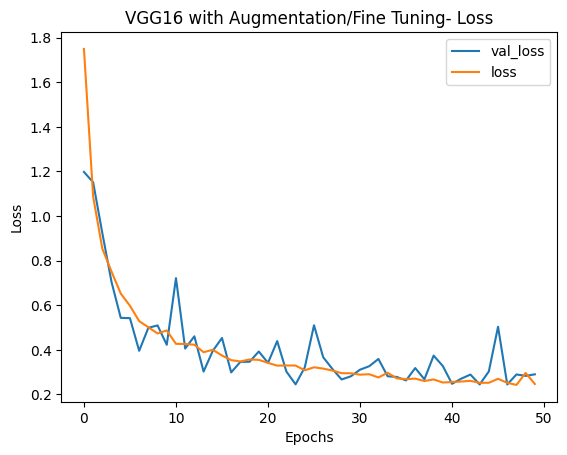

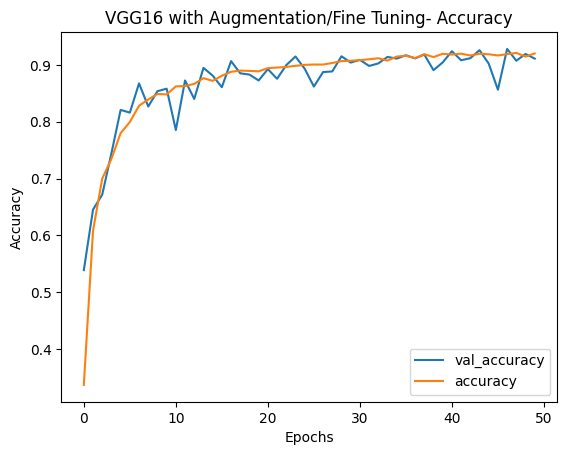

In [ ]:
#Plot the traning/validation results of our best model- Model 16
visualize_training_results(aug_vgg16_model_history)

Let's look at our predictions by class for our final model (Model 16)

In [ ]:
# final_model = tf.keras.models.load_model('aug_vgg16_model.h5', compile=False)

final_model = tf.keras.models.load_model('/content/drive/MyDrive/Data/Land_Cover_Classification_Project/aug_vgg16_model.h5', compile=False)


In [ ]:
#Predictions on entire train data
batch_size = 128
num_of_test_samples = 43
predictions = final_model.predict(aug16_test_generator,  num_of_test_samples // batch_size+1)
predictions

43/43 [==============================] - 17s 387ms/step


array([[9.9993384e-01, 4.6584977e-19, 5.0097464e-09, ..., 2.2567428e-28,
        5.9878697e-05, 7.7555752e-13],
       [9.7196454e-01, 3.0293207e-18, 5.4901119e-07, ..., 1.4873510e-18,
        1.4426853e-04, 1.2356460e-12],
       [9.7947717e-01, 1.5439530e-14, 2.7877314e-09, ..., 1.5500134e-22,
        2.0497765e-02, 1.1870964e-07],
       ...,
       [6.2766770e-09, 1.4805388e-08, 6.3541819e-08, ..., 1.4938526e-32,
        8.1292528e-10, 9.9999988e-01],
       [1.3209623e-07, 1.4492950e-06, 1.7620501e-05, ..., 1.1771010e-24,
        4.6592753e-08, 9.9998081e-01],
       [1.9305061e-07, 1.4823042e-06, 3.7175105e-06, ..., 1.6827297e-25,
        2.9074213e-08, 9.9999464e-01]], dtype=float32)

In [ ]:
#Take our highest predicted class as our prediction
y_pred = np.argmax(predictions, axis=1)

#Define our X_test or Test Classes
true_classes = aug16_test_generator.classes

#Define our y_test or Test Labels
class_labels = list(aug16_test_generator.class_indices.keys())   

report = classification_report(true_classes, y_pred, target_names=class_labels)
print(report)

                      precision    recall  f1-score   support

          AnnualCrop       0.96      0.90      0.93       600
              Forest       0.89      0.99      0.94       600
HerbaceousVegetation       0.88      0.89      0.88       600
             Highway       0.86      0.89      0.88       500
          Industrial       0.93      0.97      0.95       500
             Pasture       0.94      0.81      0.87       400
       PermanentCrop       0.87      0.89      0.88       500
         Residential       0.94      0.99      0.96       600
               River       0.93      0.85      0.89       500
             SeaLake       0.99      0.95      0.97       600

            accuracy                           0.92      5400
           macro avg       0.92      0.91      0.92      5400
        weighted avg       0.92      0.92      0.92      5400



In [ ]:
aug16_test_generator.class_indices

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

In [ ]:
cm_labels = list(aug16_test_generator.class_indices.keys())
cm_labels

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

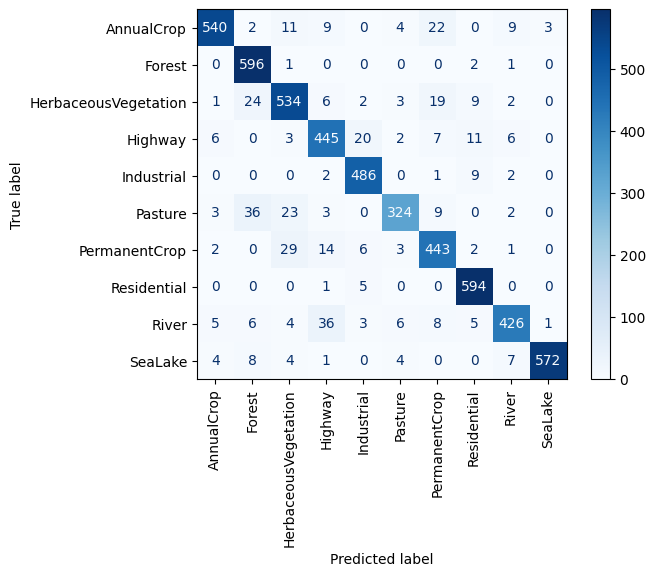

In [ ]:
#View confusion matrix of test predictions

final_disp = ConfusionMatrixDisplay.from_predictions(true_classes, y_pred, 
                                                     display_labels=cm_labels, 
                                                     xticks_rotation="vertical", 
                                                     cmap=plt.cm.Blues)

## Conclusion

### Recommendations

- Use this land cover classifier tool on images of the same land area over time.
- Focus deforestation prevention efforts on known wildlife corridor areas where an image’s class has changed over time. 

### Next Steps

Create object detection to help classify multiple areas of land cover within an image. 

### References

[1] Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification. Patrick Helber, Benjamin Bischke, Andreas Dengel, Damian Borth. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 2019.

[2] Introducing EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification. Patrick Helber, Benjamin Bischke, Andreas Dengel. 2018 IEEE International Geoscience and Remote Sensing Symposium, 2018.